# EXPERIMENT TWO : JUST-A-THOUGHT HYPOTHESIS
Baseline of this experiment : Just-a-thought indicator

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import quantstats as qt

import warnings
warnings.filterwarnings('ignore')

# aapl_path = Path.cwd().parent / 'data/aapl_h1.csv'
# raw_data = pd.read_csv(aapl_path)


parquet_path = Path.cwd().parent / 'data/eur_1d.parquet'

raw_data = pd.read_parquet(parquet_path)
raw_data = raw_data.reset_index()
raw_data.columns = raw_data.columns.str.lower()



In [2]:
# Features Engineering
data = raw_data.copy()
data = data.set_index('datetime')
data.index = pd.to_datetime(data.index)
data = data.dropna(axis=0)
data

,open,high,low,close,volume
datetime,,,,,
2010-01-03,1.43010,1.43370,1.42570,1.42900,0
2010-01-04,1.42890,1.44560,1.42690,1.44270,0
2010-01-05,1.44260,1.44830,1.43340,1.43550,0
2010-01-06,1.43560,1.44470,1.42830,1.44000,0
2010-01-07,1.43990,1.44040,1.42990,1.43130,0
...,...,...,...,...,...
2023-12-25,1.10025,1.10286,1.09974,1.10224,0
2023-12-26,1.10223,1.10450,1.10085,1.10416,0
2023-12-27,1.10416,1.11226,1.10364,1.11102,0


In [3]:
# Define Parameters
lookback = 10
ema_length = 200

In [4]:
# Calculate daily returns and fill missing values with a small number
data['returns'] = data['close'].pct_change().fillna(1e-5)

# Calculate the Average True Range (ATR) multiplied by a lookback period
data['atr'] = (ta.atr(data['high'], data['low'], data['close'], 14) * lookback) / data['close']

# Shift the ATR by the lookback period for later use in normalization
data['atr_shift'] = data['atr'].shift(lookback)

# Calculate cumulative returns over the lookback window
data['cum_returns'] = data['returns'].rolling(window=lookback).sum()

# Calculate the Exponential Moving Average (EMA) of the close prices
data['ema'] = ta.ema(data['close'], ema_length)

# Calculate 'alpha' as the ratio of cumulative returns to the shifted ATR
data['alpha'] = data['cum_returns'] / data['atr_shift']

# Smooth 'alpha' using an EMA over 50 periods
data['alpha_ma'] = ta.ema(data['alpha'], 50)

# Remove any rows with missing values which may have been caused by rolling or shifting
data.dropna(axis=0, inplace=True)

# Define the condition for a 'long' signal based on 'alpha' and price being above the EMA
data['condition_long'] = np.where((data['alpha'] > data['alpha_ma']) & (data['close'] > data['ema']), 1, 0)

# Create trading signals based on the condition for going long
data['signals'] = data['condition_long'].shift()

# Calculate the strategy returns by multiplying the signals with the asset's returns
returns = data['signals'] * data['returns']

In [5]:
(returns != 0).value_counts()

False    3199
True      970
Name: count, dtype: int64

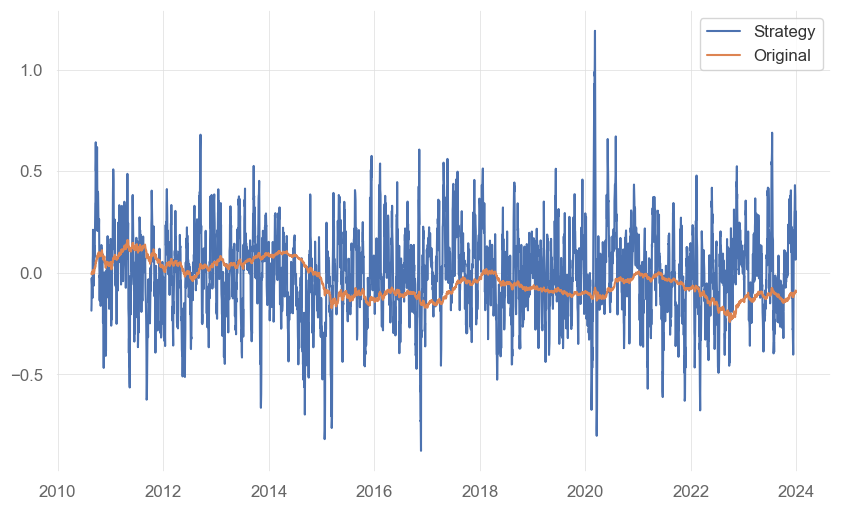

In [10]:
plt.plot(data['alpha'], label='Strategy')
plt.plot(np.cumsum(data['returns']), label='Original')
plt.legend()
plt.show()

In [7]:
_ret = returns.copy()
_ret = _ret.replace([np.inf, -np.inf, np.nan, -0.], 0).astype(float)

                           Strategy
-------------------------  ----------
Start Period               2010-08-23
End Period                 2023-12-29
Risk-Free Rate             0.0%
Time in Market             24.0%

Cumulative Return          0.9%
CAGR﹪                     0.05%

Sharpe                     0.03
Prob. Sharpe Ratio         55.32%
Smart Sharpe               0.03
Sortino                    0.04
Smart Sortino              0.04
Sortino/√2                 0.03
Smart Sortino/√2           0.03
Omega                      1.01

Max Drawdown               -14.9%
Longest DD Days            3670
Volatility (ann.)          3.52%
Calmar                     0.0
Skew                       -1.58
Kurtosis                   32.52

Expected Daily %           0.0%
Expected Monthly %         0.01%
Expected Yearly %          0.06%
Kelly Criterion            0.59%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.36%
Expected Shortfall (cVaR)  -0.36%

Max Consecutive Wins       10
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2013-12-12,2016-11-09,2023-12-29,3670,-14.901078,-14.760796
2,2011-06-08,2012-10-23,2013-12-08,915,-6.495310,-6.163239
3,2010-10-17,2011-01-17,2011-01-31,107,-2.738263,-2.665922
4,2011-05-05,2011-05-05,2011-06-01,28,-2.173182,-2.015695
5,2011-02-02,2011-02-20,2011-03-02,29,-1.724919,-1.595553


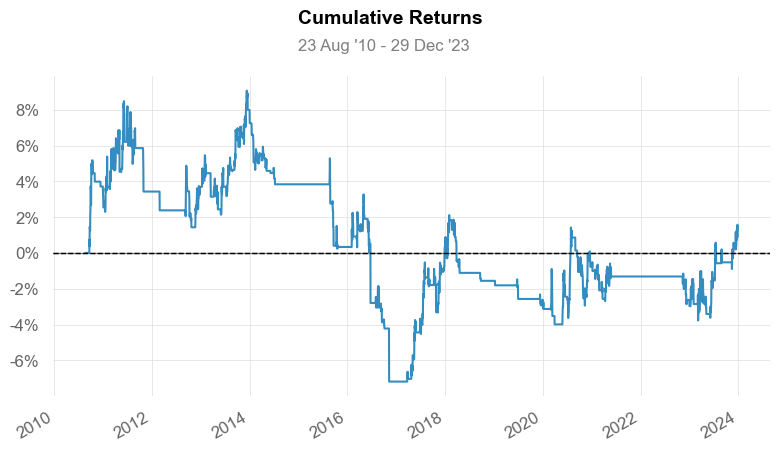

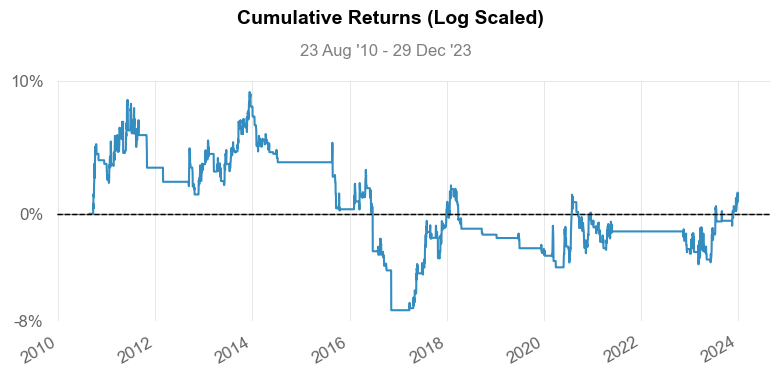

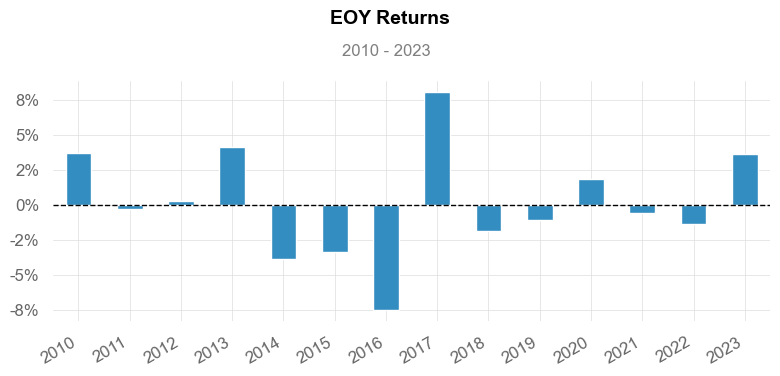

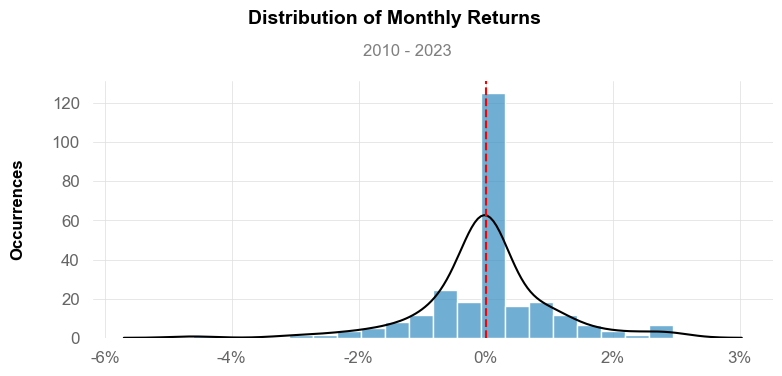

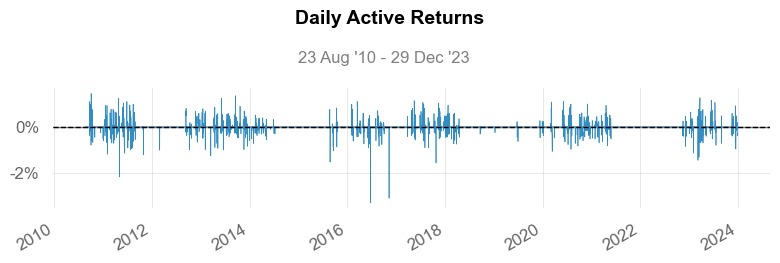

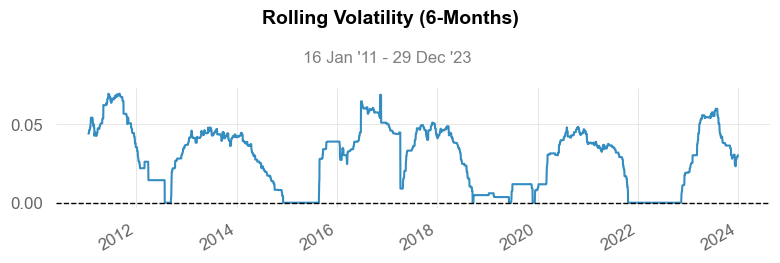

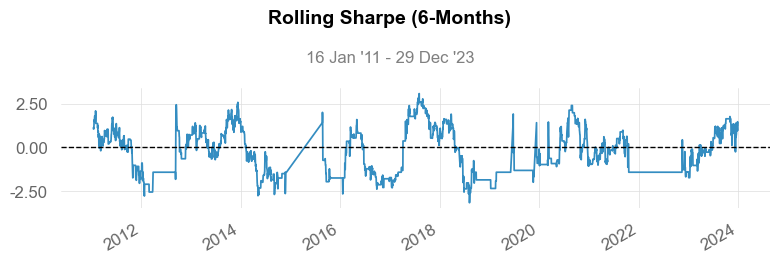

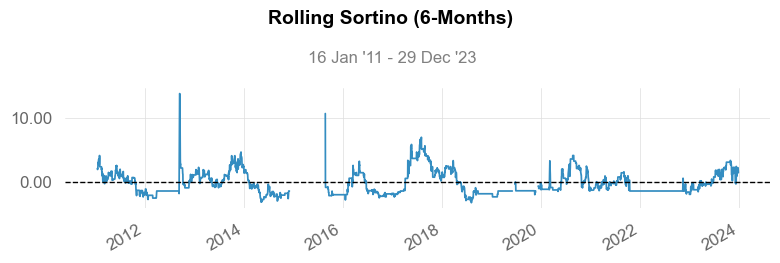

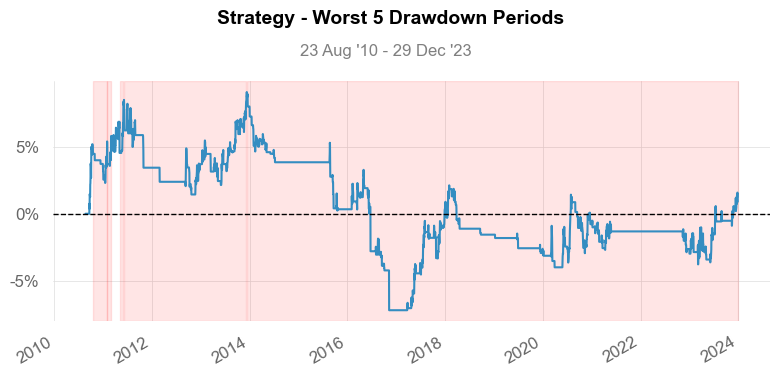

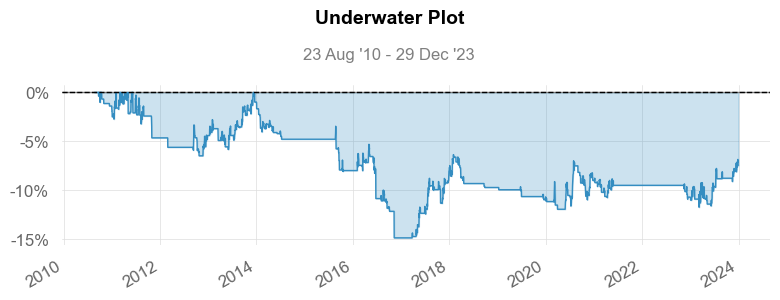

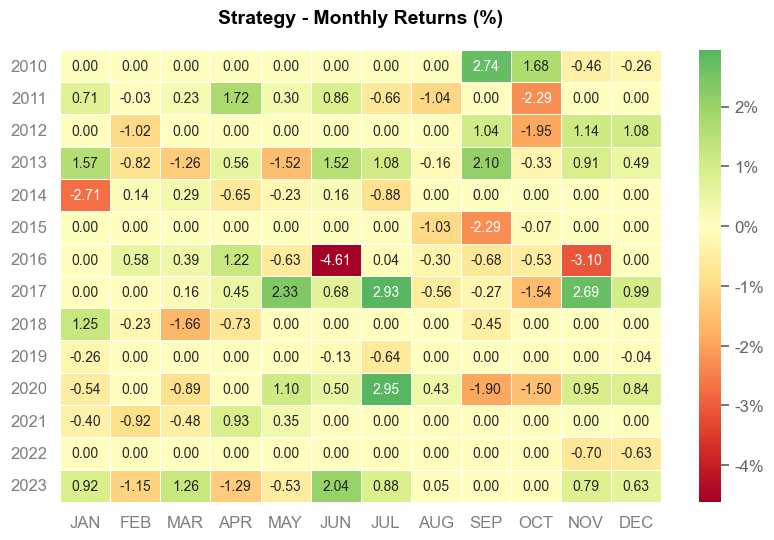

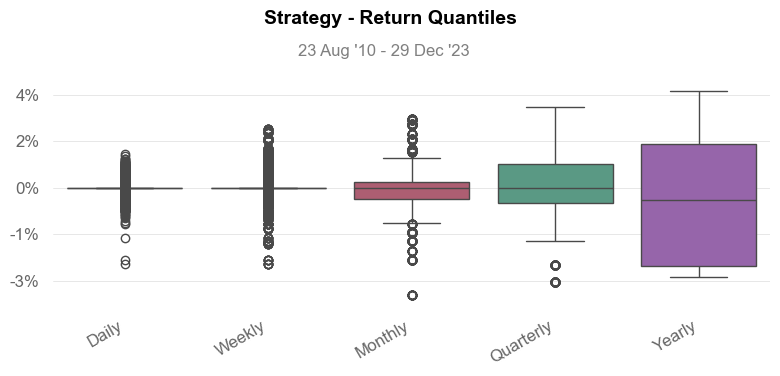

In [8]:
qt.reports.full(_ret)

In [9]:

# length = 14
# lookback = input.int(10, 'Lookback')
# plot_lback = input.int(14, 'Percentile Lookback')

# atr = ta.atr(length) * lookback
# ret = close - close[1]

# ma200 = ta.ema(close, 200)

# last_rets = 0. // cum_returns
# for i = 1 to lookback
#     last_rets += ret[i]

# lookback_ret = last_rets / atr[lookback] // alpha

# ma_lr = ta.ema(lookback_ret, 9)
# ma_lr_mid = ta.ema(lookback_ret, 21)
# ma_lr_slow = ta.ema(lookback_ret, 50)

# plot(lookback_ret)
# plot(ma_lr, color=color.lime)
# plot(ma_lr_mid, color=color.yellow)
# plot(ma_lr_slow, color=color.red)

# // var returnss = 0.

# // cond_long = (lookback_ret > ma_lr_slow) and (close > ma200)
# // // cond_short = (lookback_ret > ma_lr_slow) and (close < ma200)

# // if cond_long[1]
# //     returnss += ret / close[1]

# // if cond_short[1]
# //     returnss +=  -1 * (ret / close[1])

# // plot(returnss)


# // plot(ma_lr, color=color.yellow)
# // plot(ma_lr_mid, color=color.white,linewidth=2)
# // plot(ma_lr_slow, color=color.white, linewidth=2)

# // Rolling Quantiles
# // upper_band = ta.percentile_nearest_rank(lookback_ret, plot_lback, 90)
# // lower_band = ta.percentile_nearest_rank(lookback_ret, plot_lback, 10)

# // plot(upper_band, color=color.lime)
# // plot(lower_band, color=color.red)
